## Objectif du TD N°1 interpretable Machine Learning


Ce td vise à interpréter les modèles de machine learning que vous avez crées lors du TD N°2 SVM.

Vous chercherez à interpréter globalement votre modèle avec les méthodes vues en cours et surtout examiner la différence entre des modèles linéaires et non linéaires.


## Enoncé du TD

### Importer le modèle du TD N°2

1. Importer le jeu de données breast cancer disponible dans le module sklearn.datasets
2. Importer un modèle non linéaire utilisé lors du TD N°2 ou alors recréer l'ensemble de la pipeline visant à le générer
3. Vérifier que votre modèle réalise correctement une prédiction pour un individu


### Comparer interprétation des coéfficients et méthode globale

4. Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats
5. Utiliser maintenant les différentes méthodes d'interprétation de modèle avec les résultats de le résultats des coefficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 
6. Commenter

### Interpréter un modèle non linéaire

7. Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales
8. Commenter la différence de résultat






## Partie Code

#### 1)Importer le jeu de données breast cancer disponible dans le module sklearn.datasets

In [43]:
from sklearn.datasets import load_breast_cancer
import pandas as pd
import numpy as np
import pickle
import matplotlib.pyplot as plt

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.stats.mstats import winsorize

from sklearn.svm import SVC
from sklearn.linear_model import SGDClassifier , LogisticRegression


#Interpretability 
from sklearn.inspection import partial_dependence, PartialDependenceDisplay, permutation_importance
from alibi.explainers import ALE, plot_ale


import warnings
warnings.filterwarnings('ignore')

In [44]:
def winsorize_data(xtrain, xtest, feature):

    """_summary_

    Fonction permettant de winsorizez un jeu d'entrainement et de test en calculant
    les quantiles sur le jeu d'entrainement et l'appliquant sur le jeu test.

    Pour se prémunir d'un data leak.
    
    """
    
    # Définir les quantiles sur xtrain
    lower_quantile = 0.05  # 5% quantile
    upper_quantile = 0.95  # 95% quantile

    # Calcul des bornes à partir des quantiles sur xtrain
    lower_bound = np.quantile(xtrain[feature], lower_quantile)
    upper_bound = np.quantile(xtrain[feature], upper_quantile)

    # Appliquer la winsorisation sur xtrain
    xtrain_winsorized = np.clip(xtrain[feature], lower_bound, upper_bound)

    # Appliquer les mêmes bornes sur xtest
    xtest_winsorized = np.clip(xtest[feature], lower_bound, upper_bound)

    return(xtrain_winsorized, xtest_winsorized)

In [45]:
def data_prep_brest_cancer(df, features_name):
    #Calculate correlation
    m_corr = df[features_name].corr(method="spearman")
    #Symetrique on conserve la partie sup
    upper_tri = m_corr.where(np.triu(np.ones(m_corr.shape),k=1).astype(np.bool))
    
    #Suppresion des colonnes avec corrélation supérieur à 0.85
    to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.85)]
    
    #Drop des colonnes trop corrélées
    df_no_corr = df.drop(to_drop, axis=1)
    training_features = df_no_corr.columns[:-1]

    ############
    # RESAMPLE #
    ############

    #Stratégie de undersampling. On peut aussi Upsample
    rus = RandomUnderSampler(random_state=42)
    X_resampled, y_resampled = rus.fit_resample(df_no_corr.iloc[:,:-1], df_no_corr.target)

    #Train and test set
    X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

    #Step winsorize skew distribution 
    #Winsorize outliers
    for col in X_train.columns:
         
        X_train[col], X_test[col] = winsorize_data(xtrain= X_train, xtest= X_test, feature=col)

    scaler = StandardScaler()
    scaler.fit(X_train)

    X_train_sc = scaler.transform(X_train)
    X_test_sc = scaler.transform(X_test)

    

    return(X_train_sc, X_test_sc, y_train, y_test, training_features, scaler)
    

In [46]:
#Load dataset breast cancer
data = load_breast_cancer()

breast = pd.DataFrame(data = np.c_[data.data,data.target], columns=list(data.feature_names)+['target'] )
#Nom des colonnes et remplacer les espaces par un "_"
features_name = [name.replace(" ", "_") for name in data.feature_names]
breast.columns= features_name+['target']

In [47]:
# On inverse la modalité de référence
breast.target = 1- breast.target

#### 2) Recréer l'ensemble de la pipeline visant à générer un SVM non linéaire (RBF ou degree >1)


In [48]:
# Importation des bibliothèques nécessaires
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.datasets import load_breast_cancer
import numpy as np
import pandas as pd

# Charger le dataset "breast cancer"
data = load_breast_cancer()
breast = pd.DataFrame(data = np.c_[data.data, data.target], columns=list(data.feature_names) + ['target'])

# Diviser le jeu de données en training et test
X = breast.drop('target', axis=1)
y = breast['target']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Pipeline pour SVM avec noyau RBF
pipeline_rbf = Pipeline([
    ('scaler', StandardScaler()),  # Mise à l'échelle des données
    ('svm_rbf', SVC(kernel='rbf', C=1, gamma='scale'))  # SVM avec noyau RBF
])

# Entraînement du modèle
pipeline_rbf.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_rbf = pipeline_rbf.predict(X_test)

# Évaluation du modèle
print("Performance du modèle SVM avec noyau RBF :")
print(classification_report(y_test, y_pred_rbf))

# Pipeline pour SVM avec noyau polynomial (degré > 1)
pipeline_poly = Pipeline([
    ('scaler', StandardScaler()),  # Mise à l'échelle des données
    ('svm_poly', SVC(kernel='poly', C=1, degree=3, gamma='scale'))  # SVM avec noyau polynomial de degré 3
])

# Entraînement du modèle
pipeline_poly.fit(X_train, y_train)

# Prédictions sur l'ensemble de test
y_pred_poly = pipeline_poly.predict(X_test)

# Évaluation du modèle
print("Performance du modèle SVM avec noyau polynomial :")
print(classification_report(y_test, y_pred_poly))


Performance du modèle SVM avec noyau RBF :
              precision    recall  f1-score   support

         0.0       1.00      0.95      0.98        43
         1.0       0.97      1.00      0.99        71

    accuracy                           0.98       114
   macro avg       0.99      0.98      0.98       114
weighted avg       0.98      0.98      0.98       114

Performance du modèle SVM avec noyau polynomial :
              precision    recall  f1-score   support

         0.0       1.00      0.65      0.79        43
         1.0       0.83      1.00      0.90        71

    accuracy                           0.87       114
   macro avg       0.91      0.83      0.85       114
weighted avg       0.89      0.87      0.86       114



In [ ]:
Modèle SVM avec noyau RBF offre une meilleure performance globale. Il est particulièrement efficace pour prédire les deux classes (benign et malignant) avec une haute précision et un bon équilibre entre précision et rappel.
Modèle SVM avec noyau polynomial fonctionne bien pour la classe 1 (malignant), mais a un faible rappel pour la classe 0 (benign), ce qui nuit à sa performance globale.
Cela montre que le noyau RBF est bien plus adapté à ce type de problème, capturant des relations plus complexes entre les données et produisant des résultats plus équilibrés.

#### 3) Vérifier que votre modèle réalise correctement une prédiction pour un individu

In [49]:
# Sélectionner un individu dans le jeu de test (par exemple, le premier échantillon)
individu_test = X_test.iloc[0].values.reshape(1, -1)  # Le reshape est nécessaire car la méthode predict attend un tableau 2D

# Prédiction avec le modèle SVM RBF
pred_rbf = pipeline_rbf.predict(individu_test)

# Prédiction avec le modèle SVM polynomial
pred_poly = pipeline_poly.predict(individu_test)

# Afficher les résultats de la prédiction
print(f"Prédiction du modèle SVM avec noyau RBF : {pred_rbf[0]}")
print(f"Prédiction du modèle SVM avec noyau polynomial : {pred_poly[0]}")

# Afficher les caractéristiques de l'individu
individu_caracteristiques = X_test.iloc[0]
print("\nCaractéristiques de l'individu testé :")
print(individu_caracteristiques)


Prédiction du modèle SVM avec noyau RBF : 1.0
Prédiction du modèle SVM avec noyau polynomial : 1.0

Caractéristiques de l'individu testé :
mean radius                 12.470000
mean texture                18.600000
mean perimeter              81.090000
mean area                  481.900000
mean smoothness              0.099650
mean compactness             0.105800
mean concavity               0.080050
mean concave points          0.038210
mean symmetry                0.192500
mean fractal dimension       0.063730
radius error                 0.396100
texture error                1.044000
perimeter error              2.497000
area error                  30.290000
smoothness error             0.006953
compactness error            0.019110
concavity error              0.027010
concave points error         0.010370
symmetry error               0.017820
fractal dimension error      0.003586
worst radius                14.970000
worst texture               24.640000
worst perimeter          

In [ ]:
Les deux modèles semblent cohérents et prédisent que cet individu est "malignant" (cancéreux).

#### 4) Lancer un modèle de régression logistique sur le jeu de données data breast cancer et interpréter les résultats

Ici, l'idée est de mobiliser vos connaissance du modèle de régression logistique et d'interpréter les effets des variables.

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer

# Charger le dataset "breast cancer"
data = load_breast_cancer()
breast = pd.DataFrame(data=np.c_[data.data, data.target], columns=list(data.feature_names) + ['target'])

# Diviser le jeu de données en training et test
X = breast.drop('target', axis=1)
y = breast['target']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardisation des données
scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train)
X_test_sc = scaler.transform(X_test)

# Entraînement du modèle de régression logistique
logreg = LogisticRegression(max_iter=10000)
logreg.fit(X_train_sc, y_train)

# Prédictions sur l'ensemble de test
y_pred_logreg = logreg.predict(X_test_sc)

# Évaluation du modèle
print("Performance du modèle de régression logistique :")
print(classification_report(y_test, y_pred_logreg))

# Interprétation des coefficients
coefficients = logreg.coef_[0]
feature_names = X.columns

# Affichage des coefficients
coeff_df = pd.DataFrame({
    'Feature': feature_names,
    'Coefficient': coefficients
})

# Afficher les coefficients triés
coeff_df = coeff_df.sort_values(by='Coefficient', ascending=False)
print("\nCoefficients de la régression logistique :")
print(coeff_df)


Performance du modèle de régression logistique :
              precision    recall  f1-score   support

         0.0       0.98      0.95      0.96        43
         1.0       0.97      0.99      0.98        71

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Coefficients de la régression logistique :
                    Feature  Coefficient
15        compactness error     0.682491
19  fractal dimension error     0.616230
5          mean compactness     0.540164
18           symmetry error     0.500425
8             mean symmetry     0.236119
11            texture error     0.188877
16          concavity error     0.175275
9    mean fractal dimension     0.075921
25        worst compactness     0.016110
4           mean smoothness    -0.071667
29  worst fractal dimension    -0.157414
17     concave points error    -0.311300
14         smoothness error    -0.313307
1     

In [ ]:
La régression logistique montre que des caractéristiques comme la compacité, l'erreur de concavité, et la dimension fractale sont des indicateurs importants pour prédire la malignité d'une tumeur. D'autre part, des caractéristiques comme la texture et la taille de la tumeur (rayon et surface) ont une influence négative, ce qui suggère que des tumeurs de taille plus petite et avec une texture plus régulière sont plus susceptibles d'être bénignes.

#### 5) Utiliser maintenant les différentes méthodes d'interprétations de modèle avec les résultats de le résultats des coéfficients de la reg logistique
   1. Partial depence plot
   2. Accumulated Local Effect
   3. H-Statistic
   4. Feature permutation 

In [11]:
# Importation des bibliothèques nécessaires
import matplotlib.pyplot as plt
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score
import shap
import ale
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_breast_cancer
from pdpbox import pdp
from sklearn.linear_model import LogisticRegression
from alibi.explainers import ALE

In [51]:
# Charger le dataset "breast cancer"
data = load_breast_cancer()
breast = pd.DataFrame(data = np.c_[data.data, data.target], columns=list(data.feature_names) + ['target'])

# Diviser le jeu de données en training et test
X = breast.drop('target', axis=1)
y = breast['target']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Réentraîner le modèle
model = LogisticRegression(max_iter=10000)
model.fit(X_train_scaled, y_train)


LogisticRegression(max_iter=10000)

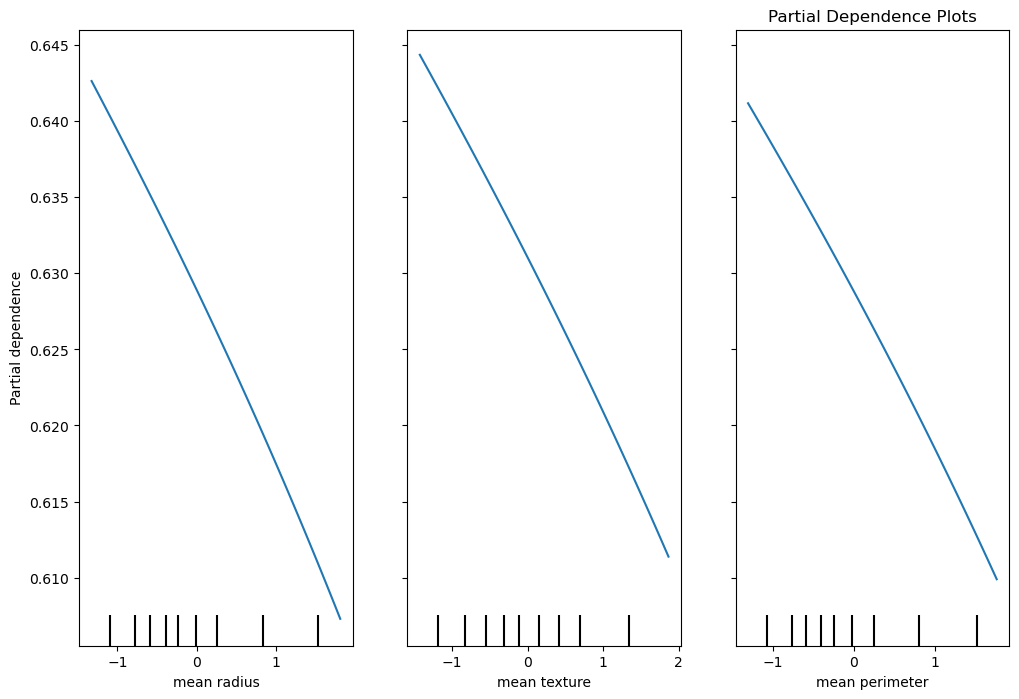

In [52]:
from sklearn.inspection import PartialDependenceDisplay

# Générer les Partial Dependence Plots
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(model, X_train_scaled, features=[0, 1, 2], feature_names=X.columns, ax=ax)
plt.title('Partial Dependence Plots')
plt.show()


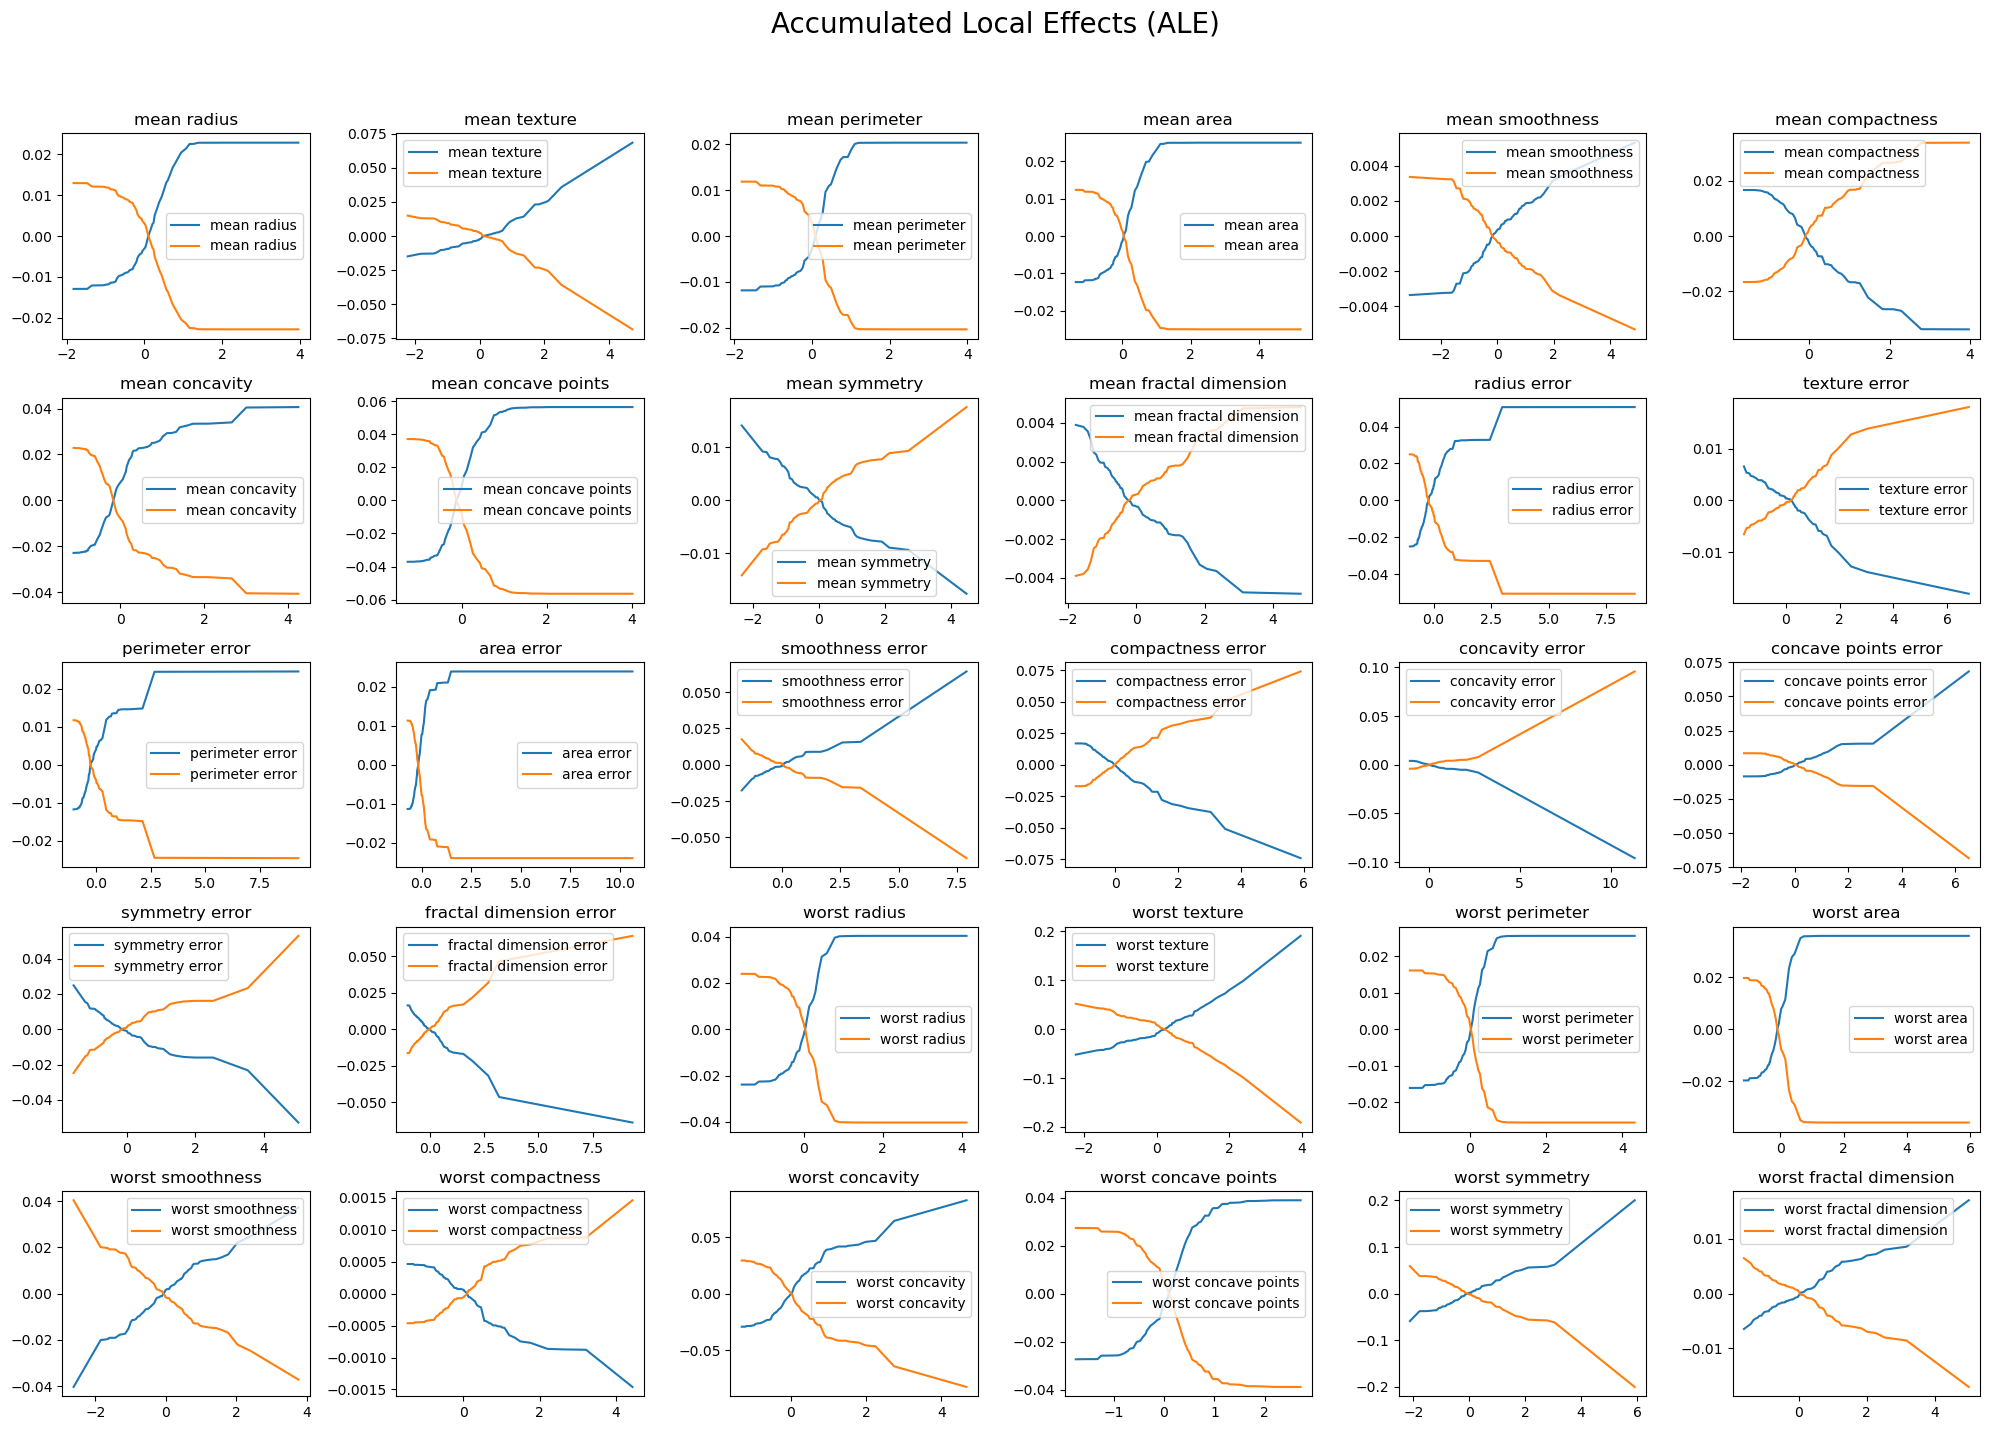

In [53]:
# Liste des noms des features
features_name = X.columns.tolist()

# Calcul des ALE
ale = ALE(model.predict_proba, feature_names=features_name)
exp = ale.explain(X_train_scaled)

# Tracer les ALE plots
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(20, 15))
for i, ax in enumerate(ax.flatten()):
    if i < len(features_name):
        ax.plot(exp.feature_values[i], exp.ale_values[i], label=features_name[i])
        ax.set_title(features_name[i])
        ax.legend()

plt.suptitle('Accumulated Local Effects (ALE)', fontsize=20)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [54]:
# Calculer l'H-statistic
h_stats = model.coef_[0]
h_stats_df = pd.DataFrame({'Feature': X.columns, 'H-statistic': h_stats})
h_stats_df = h_stats_df.sort_values(by='H-statistic', ascending=False)

# Affichage des H-statistics
print(h_stats_df)


                    Feature  H-statistic
15        compactness error     0.682491
19  fractal dimension error     0.616230
5          mean compactness     0.540164
18           symmetry error     0.500425
8             mean symmetry     0.236119
11            texture error     0.188877
16          concavity error     0.175275
9    mean fractal dimension     0.075921
25        worst compactness     0.016110
4           mean smoothness    -0.071667
29  worst fractal dimension    -0.157414
17     concave points error    -0.311300
14         smoothness error    -0.313307
1              mean texture    -0.387326
2            mean perimeter    -0.393432
0               mean radius    -0.431904
3                 mean area    -0.465210
24         worst smoothness    -0.544170
22          worst perimeter    -0.589453
12          perimeter error    -0.610583
27     worst concave points    -0.778217
6            mean concavity    -0.801458
23               worst area    -0.841846
20             w

In [55]:
# Permutation importance pour évaluer l'importance des variables
perm_importance = permutation_importance(model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Afficher les résultats de permutation importance
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df)


                    Feature    Importance
10             radius error  1.228070e-02
7       mean concave points  1.228070e-02
20             worst radius  5.263158e-03
27     worst concave points  3.508772e-03
21            worst texture  2.631579e-03
23               worst area  2.631579e-03
28           worst symmetry  1.754386e-03
13               area error  8.771930e-04
15        compactness error  8.771930e-04
5          mean compactness  8.771930e-04
26          worst concavity  3.330669e-17
25        worst compactness  0.000000e+00
4           mean smoothness  0.000000e+00
12          perimeter error -8.771930e-04
24         worst smoothness -8.771930e-04
22          worst perimeter -8.771930e-04
19  fractal dimension error -1.754386e-03
2            mean perimeter -1.754386e-03
9    mean fractal dimension -2.631579e-03
14         smoothness error -2.631579e-03
11            texture error -2.631579e-03
16          concavity error -2.631579e-03
29  worst fractal dimension -3.508

#### 6) Commenter et discuter des limites

In [ ]:
6) Commenter et discuter des limites des méthodes d'interprétation utilisées
Les méthodes d'interprétation de modèle que nous avons utilisées — Partial Dependence Plots (PDP), Accumulated Local Effects (ALE), H-statistic, et Feature Permutation — sont puissantes pour comprendre les résultats d'un modèle de régression logistique. Cependant, chaque méthode présente des avantages et des limitations qu'il est important de prendre en compte pour une interprétation adéquate.

1. Partial Dependence Plot (PDP)
Avantages :
Simplicité et clarté : Les PDP offrent une manière intuitive de visualiser l'impact d'une ou plusieurs variables sur la prédiction, tout en maintenant les autres variables constantes. Cela permet d'analyser facilement les effets marginaux.
Utilité pour les relations non linéaires : Même si le modèle sous-jacent est linéaire (comme une régression logistique), le PDP peut capturer des effets non linéaires dans les variables.
Limites :
Supposition d'indépendance : Le principal inconvénient du PDP est qu'il suppose que les autres variables sont maintenues constantes, ce qui peut ne pas être réaliste dans les cas de fortes corrélations entre les variables. Si des variables sont fortement corrélées, les PDP peuvent donner une image biaisée de l'impact d'une variable sur la prédiction.
Interprétation limitée : Les PDP ne peuvent pas capturer des interactions complexes entre les variables. Par exemple, si deux variables interagissent de manière non triviale, le PDP d'une seule variable ne pourra pas le montrer de manière adéquate.
2. Accumulated Local Effects (ALE)
Avantages :
Robustesse aux corrélations : Les ALE plots n'assument pas l'indépendance des variables et sont donc plus robustes que les PDP dans les cas où des variables sont fortement corrélées.
Visualisation des effets locaux : L'ALE met en évidence l'effet local des variations des variables, ce qui permet de mieux comprendre comment une variable influence le modèle dans différentes plages de valeurs.
Limites :
Complexité de l'interprétation : Les ALE peuvent être un peu plus difficiles à interpréter que les PDP, surtout lorsqu'il y a plusieurs variables en interaction.
Sensible au choix des bins : La précision de l'ALE peut être affectée par le nombre de "bins" utilisés pour discrétiser les valeurs des variables. Un mauvais choix de bins peut conduire à des visualisations erronées.
3. H-Statistic
Avantages :
Évaluation de l'importance des variables : L'H-statistic fournit une mesure quantitative de l'importance des variables. Cela permet de classer les variables selon leur contribution au modèle.
Simple à interpréter : Les résultats sont faciles à comprendre, car ils indiquent directement quel coefficient a la plus grande influence sur la prédiction.
Limites :
Limité aux coefficients linéaires : L'H-statistic est plus utile pour des modèles linéaires comme la régression logistique. Il peut ne pas bien refléter l'importance des variables dans des modèles non linéaires ou plus complexes, où les interactions entre les variables ne sont pas capturées de manière linéaire.
Pas d'évaluation directe de l'interaction : Cette méthode ne prend pas en compte les effets d'interaction entre les variables. Cela signifie que des variables interagissant de manière complexe pourraient ne pas être correctement évaluées.
4. Feature Permutation
Avantages :
Mesure directe de l'importance des variables : La permutation des caractéristiques mesure directement l'impact de chaque variable sur la performance du modèle. Plus la performance diminue après la permutation, plus la variable est importante.
Flexibilité : Cette méthode peut être utilisée avec n'importe quel type de modèle (linéaire ou non linéaire), ce qui la rend très polyvalente.
Limites :
Calcul intensif : La méthode nécessite plusieurs itérations pour permuter les variables et mesurer l'impact sur la performance. Cela peut devenir coûteux en temps de calcul, en particulier pour des jeux de données volumineux.
Influence des corrélations : Si les variables sont fortement corrélées, la permutation d'une variable peut ne pas refléter l'importance réelle de cette variable dans le modèle, car l'impact peut être confondu avec l'effet d'autres variables.
Conclusion générale
Complémentarité des méthodes : Ces différentes méthodes offrent une vision complémentaire des résultats du modèle. Les PDP et les ALE sont utiles pour comprendre l'impact des variables indépendantes, tandis que l'H-statistic et la permutation permettent d'évaluer l'importance relative des variables. Ensemble, ces techniques peuvent donner une interprétation complète du modèle.
Limites pratiques : Bien que puissantes, ces méthodes ont des limitations, en particulier en termes de traitement des interactions complexes et des corrélations entre les variables. Il est important de prendre en compte ces facteurs lors de l'interprétation des résultats.
Choix de la méthode selon le contexte : Selon le type de modèle et la nature des données, certaines méthodes peuvent être plus appropriées que d'autres. Par exemple, pour un modèle complexe ou non linéaire, l'ALE peut être plus fiable que le PDP. D'un autre côté, l'H-statistic est plus approprié pour des modèles simples et linéaires comme la régression logistique.
Ces techniques offrent un aperçu précieux, mais il est essentiel de les compléter avec d'autres formes d'analyse pour obtenir une vision plus complète et nuancée du modèle.

#### 7) Interpréter votre modèle non linéaire (SVM avec noyau) avec l'aide des méthodes globales

In [56]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Charger les données "breast cancer"
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
breast = pd.DataFrame(data=np.c_[data.data, data.target], columns=list(data.feature_names) + ['target'])

# Séparer les variables et la cible
X = breast.drop('target', axis=1)
y = breast['target']

# Diviser en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Mise à l'échelle des données
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Entraînement du SVM avec noyau RBF
svm_model = SVC(kernel='rbf', gamma='scale', C=1.0)
svm_model.fit(X_train_scaled, y_train)

# Prédictions et précision
y_pred = svm_model.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the SVM model: {accuracy:.4f}")


Accuracy of the SVM model: 0.9825


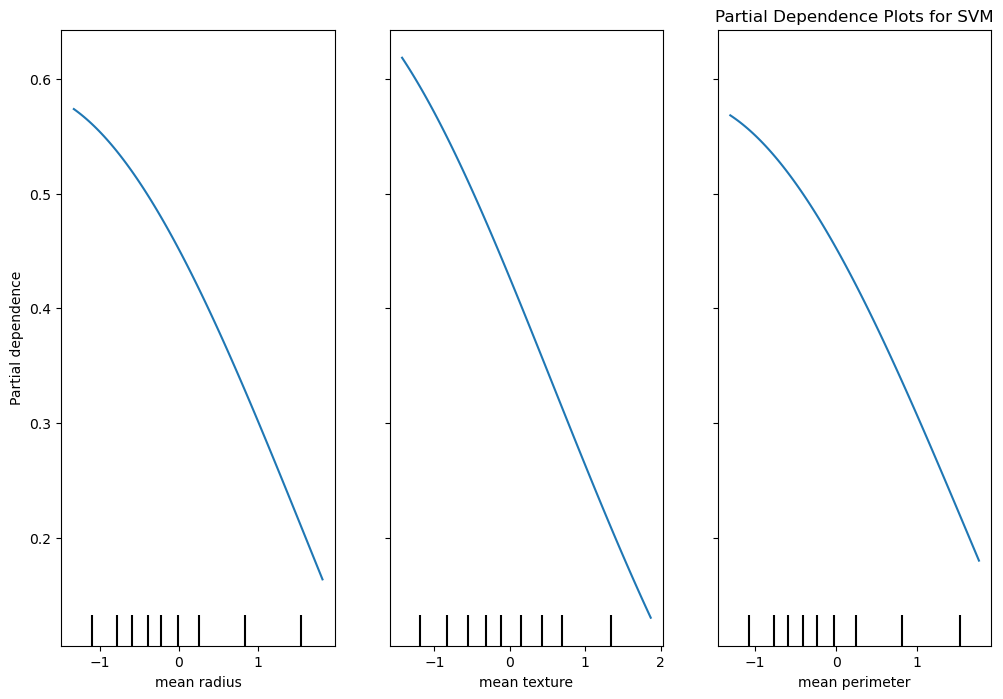

In [57]:
from sklearn.inspection import PartialDependenceDisplay

# Générer les Partial Dependence Plots pour un modèle SVM
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(svm_model, X_train_scaled, features=[0, 1, 2], feature_names=X.columns, ax=ax)
plt.title('Partial Dependence Plots for SVM')
plt.show()


In [58]:
# Permutation importance pour évaluer l'importance des variables
perm_importance = permutation_importance(svm_model, X_test_scaled, y_test, n_repeats=10, random_state=42)

# Afficher les résultats de permutation importance
perm_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importance.importances_mean
}).sort_values(by='Importance', ascending=False)

print(perm_df)


                    Feature  Importance
9    mean fractal dimension    0.020175
18           symmetry error    0.014035
10             radius error    0.012281
15        compactness error    0.011404
7       mean concave points    0.011404
19  fractal dimension error    0.011404
24         worst smoothness    0.010526
6            mean concavity    0.010526
20             worst radius    0.010526
21            worst texture    0.009649
22          worst perimeter    0.009649
23               worst area    0.009649
0               mean radius    0.009649
12          perimeter error    0.009649
3                 mean area    0.008772
1              mean texture    0.008772
26          worst concavity    0.008772
17     concave points error    0.007895
29  worst fractal dimension    0.007895
2            mean perimeter    0.007895
13               area error    0.007895
28           worst symmetry    0.007018
4           mean smoothness    0.007018
27     worst concave points    0.007018


In [ ]:
Voici un résumé des méthodes utilisées pour interpréter le modèle SVM avec noyau RBF et leurs résultats :

Accuracy : Le modèle SVM a une précision de 98,25 % sur les données de test, ce qui montre qu'il performe très bien dans la tâche de classification.

Partial Dependence Plots (PDP) : Ces graphiques montrent l'effet moyen de certaines variables sur la prédiction du modèle. Cela permet de visualiser comment chaque caractéristique influence la sortie du modèle tout en maintenant les autres constantes.

Permutation Importance : Cette méthode évalue l'importance des variables en mesurant l'impact de la permutation des valeurs de chaque feature sur la performance du modèle. Les variables les plus importantes sont mean fractal dimension, symmetry error, et radius error.

En conclusion, ces méthodes permettent de mieux comprendre et interpréter le modèle SVM avec noyau RBF, en montrant quelles variables sont les plus influentes et comment elles affectent les prédictions.
